Estamos tratando con problemas NP (Non-deterministic search, polinomial check), en los que una búsqueda exhaustiva es simplemente imposible.

El problema TSP (Travelling Sales Person) trata de encontrar en recorrido más corto que pase por todas las ciudades de un conjunto dado.


Refs:

- GA Tutorial [here](http://www.obitko.com/tutorials/genetic-algorithms/index.php)
- Compendium of NP Optimization Problems [here](http://www.csc.kth.se/~viggo/problemlist/)    
    

[[ 2 88]
 [87 84]
 [84  6]
 [99 37]
 [60 87]
 [ 8 83]
 [43 33]
 [45 66]
 [28 94]
 [ 3 56]
 [14 92]
 [88 10]
 [33 12]
 [33 85]
 [69 60]
 [67 58]
 [80 19]
 [81 30]
 [69 21]
 [78 35]] (20, 2)


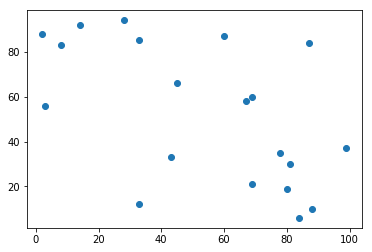

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
w_size = 100
n_cities = 20
#cities = (np.random.random((n_cities,2))*w_size).astype(int) -> ciudades aleatorias en duplas (x, y)
cities = np.array([[2, 88], [87, 84], [84, 6], [99, 37], [60, 87], [8, 83], [43, 33], [45, 66], [28, 94],
                   [3, 56], [14, 92], [88, 10], [33, 12], [33, 85], [69, 60], [67, 58], [80, 19], [81, 30],
                   [69, 21], [78, 35]]) # ciudades preprocesadas

plt.scatter(cities[:,0], cities[:,1]) # Dibujamos las ciudades en un plano xy
print (cities,cities.shape) #imprimimos las coordenadas de las ciudades

In [53]:
def TSP_plot_solution(cities, solution):
    plt.scatter(cities[:,0], cities[:,1])# las 20 ciudades cities[:,0] -> x, cities[:,1] -> y
    plt.plot(cities[solution,0].tolist()+[cities[solution[0],0]], cities[solution,1].tolist()+[cities[solution[0],1]])
    ### la linea 3 une los puntos secuencialmente según el vector solucion mediante lineas (vectores)
    
    #cities[solution,0].tolist() -> busca el x de cada una de las ciudades solucion (en orden) y las añade a una lista
    # +[cities[solution[0],0]] -> se le añade a dicha lista el primer elemento para que sea cíclico
    #cities[solution,1].tolist()+[cities[solution[0],1]] -> similar a lo realizado en el eje x

    plt.scatter(cities[solution[0],0], cities[solution[0],1], marker="x", s=60, c="red", lw="5") # punto de inicio
    plt.title("cost %.3f"%(TSP_cost(cities, solution))) # costo de la solucion
    
def TSP_cost(cities, solution):
    sol_cities = cities[solution] # ordenamos las ciudades segun la solucion
    # np.roll(sol_cities,-1, axis=0) -> shift 1 hacia la derecha, la primera ciudad es la ultima y la segunda es la primera
    # np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1))) -> suma de las distancias euclidianas
    # entre una ciudad y la siguiente, ese es el costo
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))

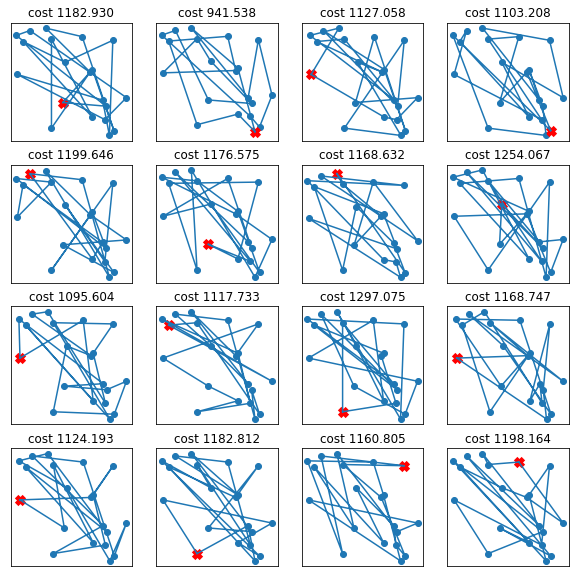

In [55]:
fig = plt.figure(figsize=(10,10)) # genera un espacio para poner los planos, un espacio de tamaño 10x10
for i in range(1,17): # iteramos 16 veces
    ax = fig.add_subplot(4,4,i) # realiza 16 planos en forma de matriz 4x4
    one_solution = np.random.permutation(n_cities) # genera aleatoriamente un vector de permutacion de las ciudades
    TSP_plot_solution(cities, one_solution) # graficamos la solucion
    ax.set_xticks([]) #quita las medidas en el eje x
    ax.set_yticks([]) #quita las medidas en el eje y

## Notas

Hay 3 parámetros importantes a la hora de analizar algoritmos genéticos (Algoritmos Bioinspirados Estocásticos):

- Tamaño de la Población
- Probabilidad de Cruce
- Probabilidad de Mutación

### Parametros generales qué necesito para concretar un problema
- Representación de la solución
- Inicializar la solución
- Función de cruce
- Función de mutación
- Función de costo

#### ¿Qué tenemos por ahora?
- La representación de la solución dada por: TSP_plot_solution
- Una manera de Inicializar una población: con np.random.permutation podemos generar muchos especímenes
- La función de costo definida: TSP_cost

#### ¿Qué nos falta?
- Función de cruce (Cross-Over)
- Una función de mutación

#### ¿Cuándo detenemos la secuencia?
##### Tenemos:
- El mejor especimen de cada generación
- La media de coste de la generación
- La desviación estandar de la población

##### ¿Qué hacer?
Al ver que la media de costo ya no disminuye mas procedemos a revisar los antecedente históricos de las mejores especies ya
que de pronto por alguna razón en una generación anterior hubo un especimen con el costo mas bajo pero se perdió por mutación o algún cruce.
OJO: Muy probablemente nos será util la solución encontrada pero nada nos garantiza que sea la mejor, puede ser que si como puede ser que no.

In [56]:
def TSP_mutate(solution, mutation_prob):
    mutated_solution = np.copy(solution) # copia de la solucion la cual será mutada
    for i in range(len(solution)): # iteramos sobre la longitud de la solución
        if np.random.random()<mutation_prob: # proceso estocástico (totalmente aleatorio) para cada elemento
            j = i+1 if i!=len(solution)-1 else 0 # si es el ultimo gen, se cambia con el primero
            tmp = mutated_solution[i]
            mutated_solution[i] = mutated_solution[j] # Todo este proceso es cambiar el gen i con el gen i+1 (swap)
            mutated_solution[j] = tmp
    return mutated_solution


def TSP_cross_over(solution1, solution2):
    l = len(solution1)
    #el cruce es estocástico
    cstart = np.random.randint(l) #se calculan dos puntos para tomar una porcion cualquiera
    cend   = np.random.randint(l-cstart)+cstart+1 # el +1 al final por la sintaxis de python en los slices de matrices
    
    r = np.zeros(l) # permutación (crosoma) resultante del cruce lleno de ceros
    s1part = solution1[cstart:cend] #s1part se refiere al slice de s1 que se heredará
    r[cstart:cend] = s1part #r va a tener el slice de solution1 en los mismos indices
    c = 0
    for i in range(l):#se itera todos los elementos de solution2 y se pregunta si estan en s1part, si esta no hace nada sigue
                      #el indice, pero si no está se agrega, de esta manera se mantiene que sea válido
        c = cend if c==cstart else c # nos saltamos los indices de s1part en r
        if not solution2[i] in s1part:
            r[c]=solution2[i]
            c += 1 #incremento el indice
            
    return r #r es una solución válida, con estos slices se intenta mantener la data de las generaciones anteriores
             #se intenta preservar la trayectoria
    
def TSP_initialize_population(n_individuals, n_cities):
    r = []
    for i in range(n_individuals):
        r.append(np.random.permutation(n_cities))
    return np.array(r)

def TSP_plot_GA_result(best, bests, means, stds): # esta función nos retorna el mejor espécimen de solución
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    plot_evolution(bests, means, stds)
    fig.add_subplot(122)
    TSP_plot_solution(cities, best)

In [57]:
%%writefile code/ga.py
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()
    

def run_ga(pop_size, init_population_function, 
           mutation_function, crossover_function, cost_function, 
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size) # Se crea población inicial
    n_xover_indivs = int(pop_size * crossover_prob)# Se multiplica el tamaño de la población con la probabilidad de cruce
                                                   # para saber cuantos individuos se cruzaran  

    means = []
    stds  = []
    best_costs = []
    best = None

    for i in range(n_iters): #n_iters -> Número de Generaciones

        #if i%(n_iters/10)==0:
        # print i
        
        # Se realiza el cruce de especies
        offsprings = []
        idx_xover_indivs = np.random.permutation(len(pop))[n_xover_indivs:] #estocásticamente se eligen los que se cruzaran
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop)) # Se elige su pareja también estocásticamente
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2) # se cruzan
            offsprings.append(offs) # Se agrega el descendiente a una lista
        offsprings = np.array(offsprings) # se convierte en array de numpy

        pop = np.vstack((pop, offsprings)).astype(int)

        # mutate population
        for j in range(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob) # se mutan algunos de la población

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop]) # se calcula una lista con los costes de los especímenes
        top_idxs  = np.argsort(costs)[:pop_size] # retorna la lista indice ordenada del menor costo al mayor
        pop = pop[top_idxs] #obtenemos la sección de la población con las poblaciones evaluadas

        costs = costs[top_idxs] #obtenemos los costos de la lista ordenada de menor a mayor costo

        means.append(np.mean(costs)) #guardamos la media de los costos por generación
        stds.append(np.std(costs)) #guardamos la media de los costos por generación
        best_costs.append(np.min(costs)) #guardamos la media de los costos por generación
        
        if best is None or np.min(costs) < cost_function(best): # si no hay mejor o el minimo costo obtenido en dicha
                                                                # generación es menor al anterior mínimo, se actualiza
            best = pop[np.argmin(costs)]
            
    #Se convierten de listas a arreglos de numpy para plt
    means      = np.array(means) 
    stds       = np.array(stds)
    best_costs = np.array(best_costs)
    return best, best_costs, means, stds

Overwriting code/ga.py


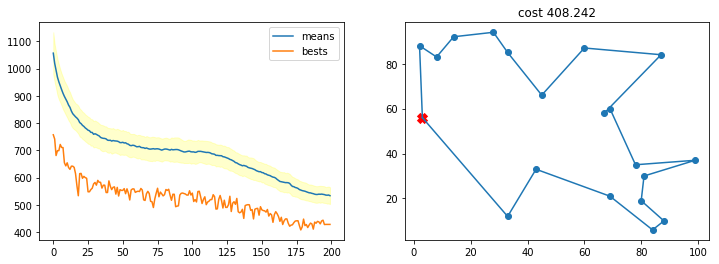

In [58]:
%run code/ga.py

r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.1, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de mutación muy pequeña

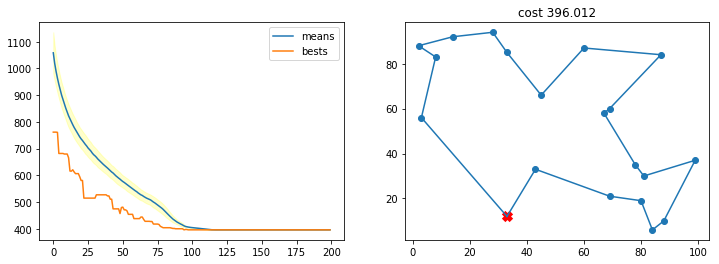

In [59]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities),  
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.01, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de cruce muy pequeña

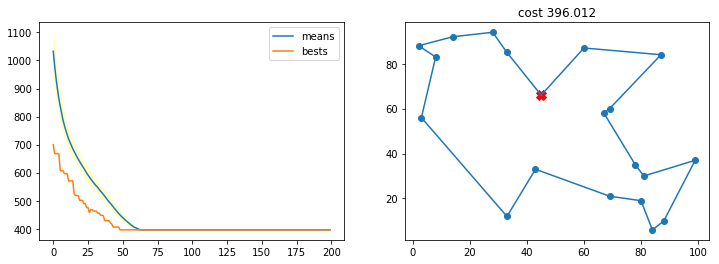

In [60]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities),  
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.01,
               mutation_prob            = 0.001, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de mutación muy alta

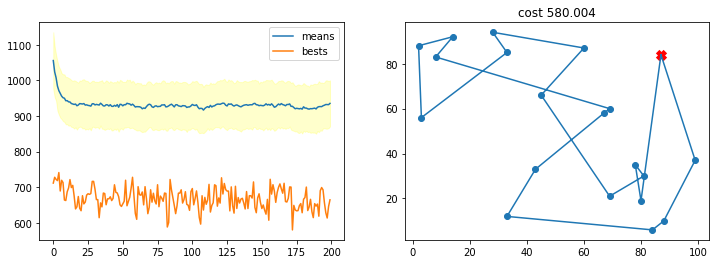

In [64]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.9, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de cruce muy alta

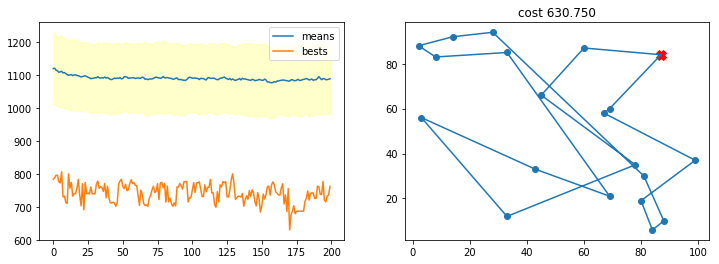

In [65]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.99,
               mutation_prob            = 0.1, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)